# Установка пакетов/библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import metrics
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Аналитическая обработка данных

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Last Курсач/data.csv')

In [4]:
#df.head()

## 0. Проверка точности модели

Для сравнения результатов точности модели будем использовать обычную регрессионную модель на основе ближайших соседей KNN

Для нас важно меньшее значение Precision ( TP/(TP+FP) ), чем большее значение Recall ( TP/(TP+FN) ), тк в нашей задаче оценки активов компаний важнее получить больше ложно предсказанных банкротов, чем вовсе их пропустить

In [5]:
reg,acc,prec,rec,t = [], [], [], [], []

def make_model(df, name = ''):
  results = pd.DataFrame(columns = ['stage','accuracy_to_max','precision_to_min','recall_to_max','time'])
  X = df.drop(['Bankrupt'], axis = 1)
  y = df.Bankrupt
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  KNC = KNeighborsClassifier()
  start_time = time.time()
  KNC.fit(x_train, y_train)
  y_pred = KNC.predict(x_test)
  
  t.append(time.time() - start_time)
  reg.append(name)
  acc.append(metrics.accuracy_score(y_test, y_pred))
  prec.append(metrics.precision_score(y_test, y_pred, average="macro"))
  rec.append(metrics.recall_score(y_test, y_pred, average="macro"))

  results['stage'] = reg
  results['accuracy_to_max'] = acc
  results['precision_to_min'] = prec
  results['recall_to_max'] = rec
  results['time'] = t
  return results


In [6]:
make_model(df, name = 'Исходные данные')

,stage,accuracy_to_max,precision_to_min,recall_to_max,time
0,Исходные данные,0.967009,0.609559,0.510492,0.326454


## 1. Описательная статистика: размер, типы переменных, пустые значения, уникальные имена и дубликаты



*   **Целевая переменная** - статус компании (банкрот/ не банкрот)
*   **Основная задача** - классификация




In [7]:
df.shape # размер

(6819, 96)

In [8]:
df.info() # информация о типе данных и количестве пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt                                                  6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [9]:
def nulls_table(df):        # проверка количества пропусков
  gg = df.isnull().sum()/len(df)*100
  dd = pd.DataFrame({'column':gg.index, 'nulls_%': gg.values}).sort_values(by = 'nulls_%', ascending=False)
  return dd[dd['nulls_%']>0]

nulls_table(df)

,column,nulls_%


In [10]:
df.duplicated().sum() # наличие дубликатов

0

In [11]:
# Удаление неинформативных признаков с помощью поиска уникальных значений
to_del = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    to_del.append(col)

to_del

[' Net Income Flag']

In [12]:
df = df.drop(to_del, axis = 1)

In [13]:
make_model(df, name = '-первичная обработка')

,stage,accuracy_to_max,precision_to_min,recall_to_max,time
0,Исходные данные,0.967009,0.609559,0.510492,0.326454
1,-первичная обработка,0.972874,0.736784,0.513137,0.505876


## Сбалансированность данных

Учитывая задачу проекта, и теперь, когда у нас есть общий обзор наших данных, нам нужно сосредоточить наше внимание на признаке, который мы планируем предсказывать: какое количество компаний является финансово стабильными и нестабильными

In [14]:
print(df['Bankrupt'].value_counts())
print('-'* 30)
print('Финансово стабильные компании: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100, 2), '% от данных')
print('Финансово не стабильные компании: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100, 2), '% от данных')

0    6599
1     220
Name: Bankrupt, dtype: int64
------------------------------
Финансово стабильные компании:  96.77 % от данных
Финансово не стабильные компании:  3.23 % от данных


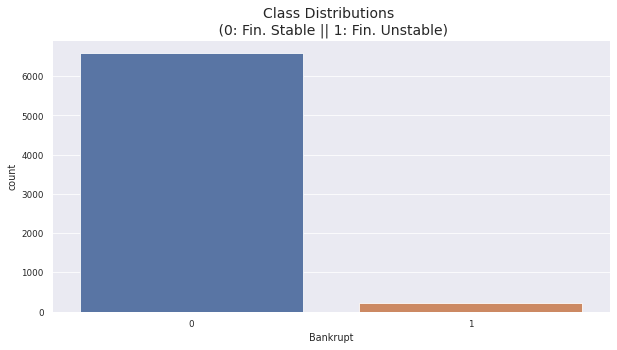

In [15]:
sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(df['Bankrupt'])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
plt.show()

Замечаем, что реальные данные плохо сбалансированны, что при решении задачи регрессии модель будет наивно предсказывать класс большинства

Вернемся к балансированию данны чуть позже, после обработки выбрасов

## 2. Удаление выбросов

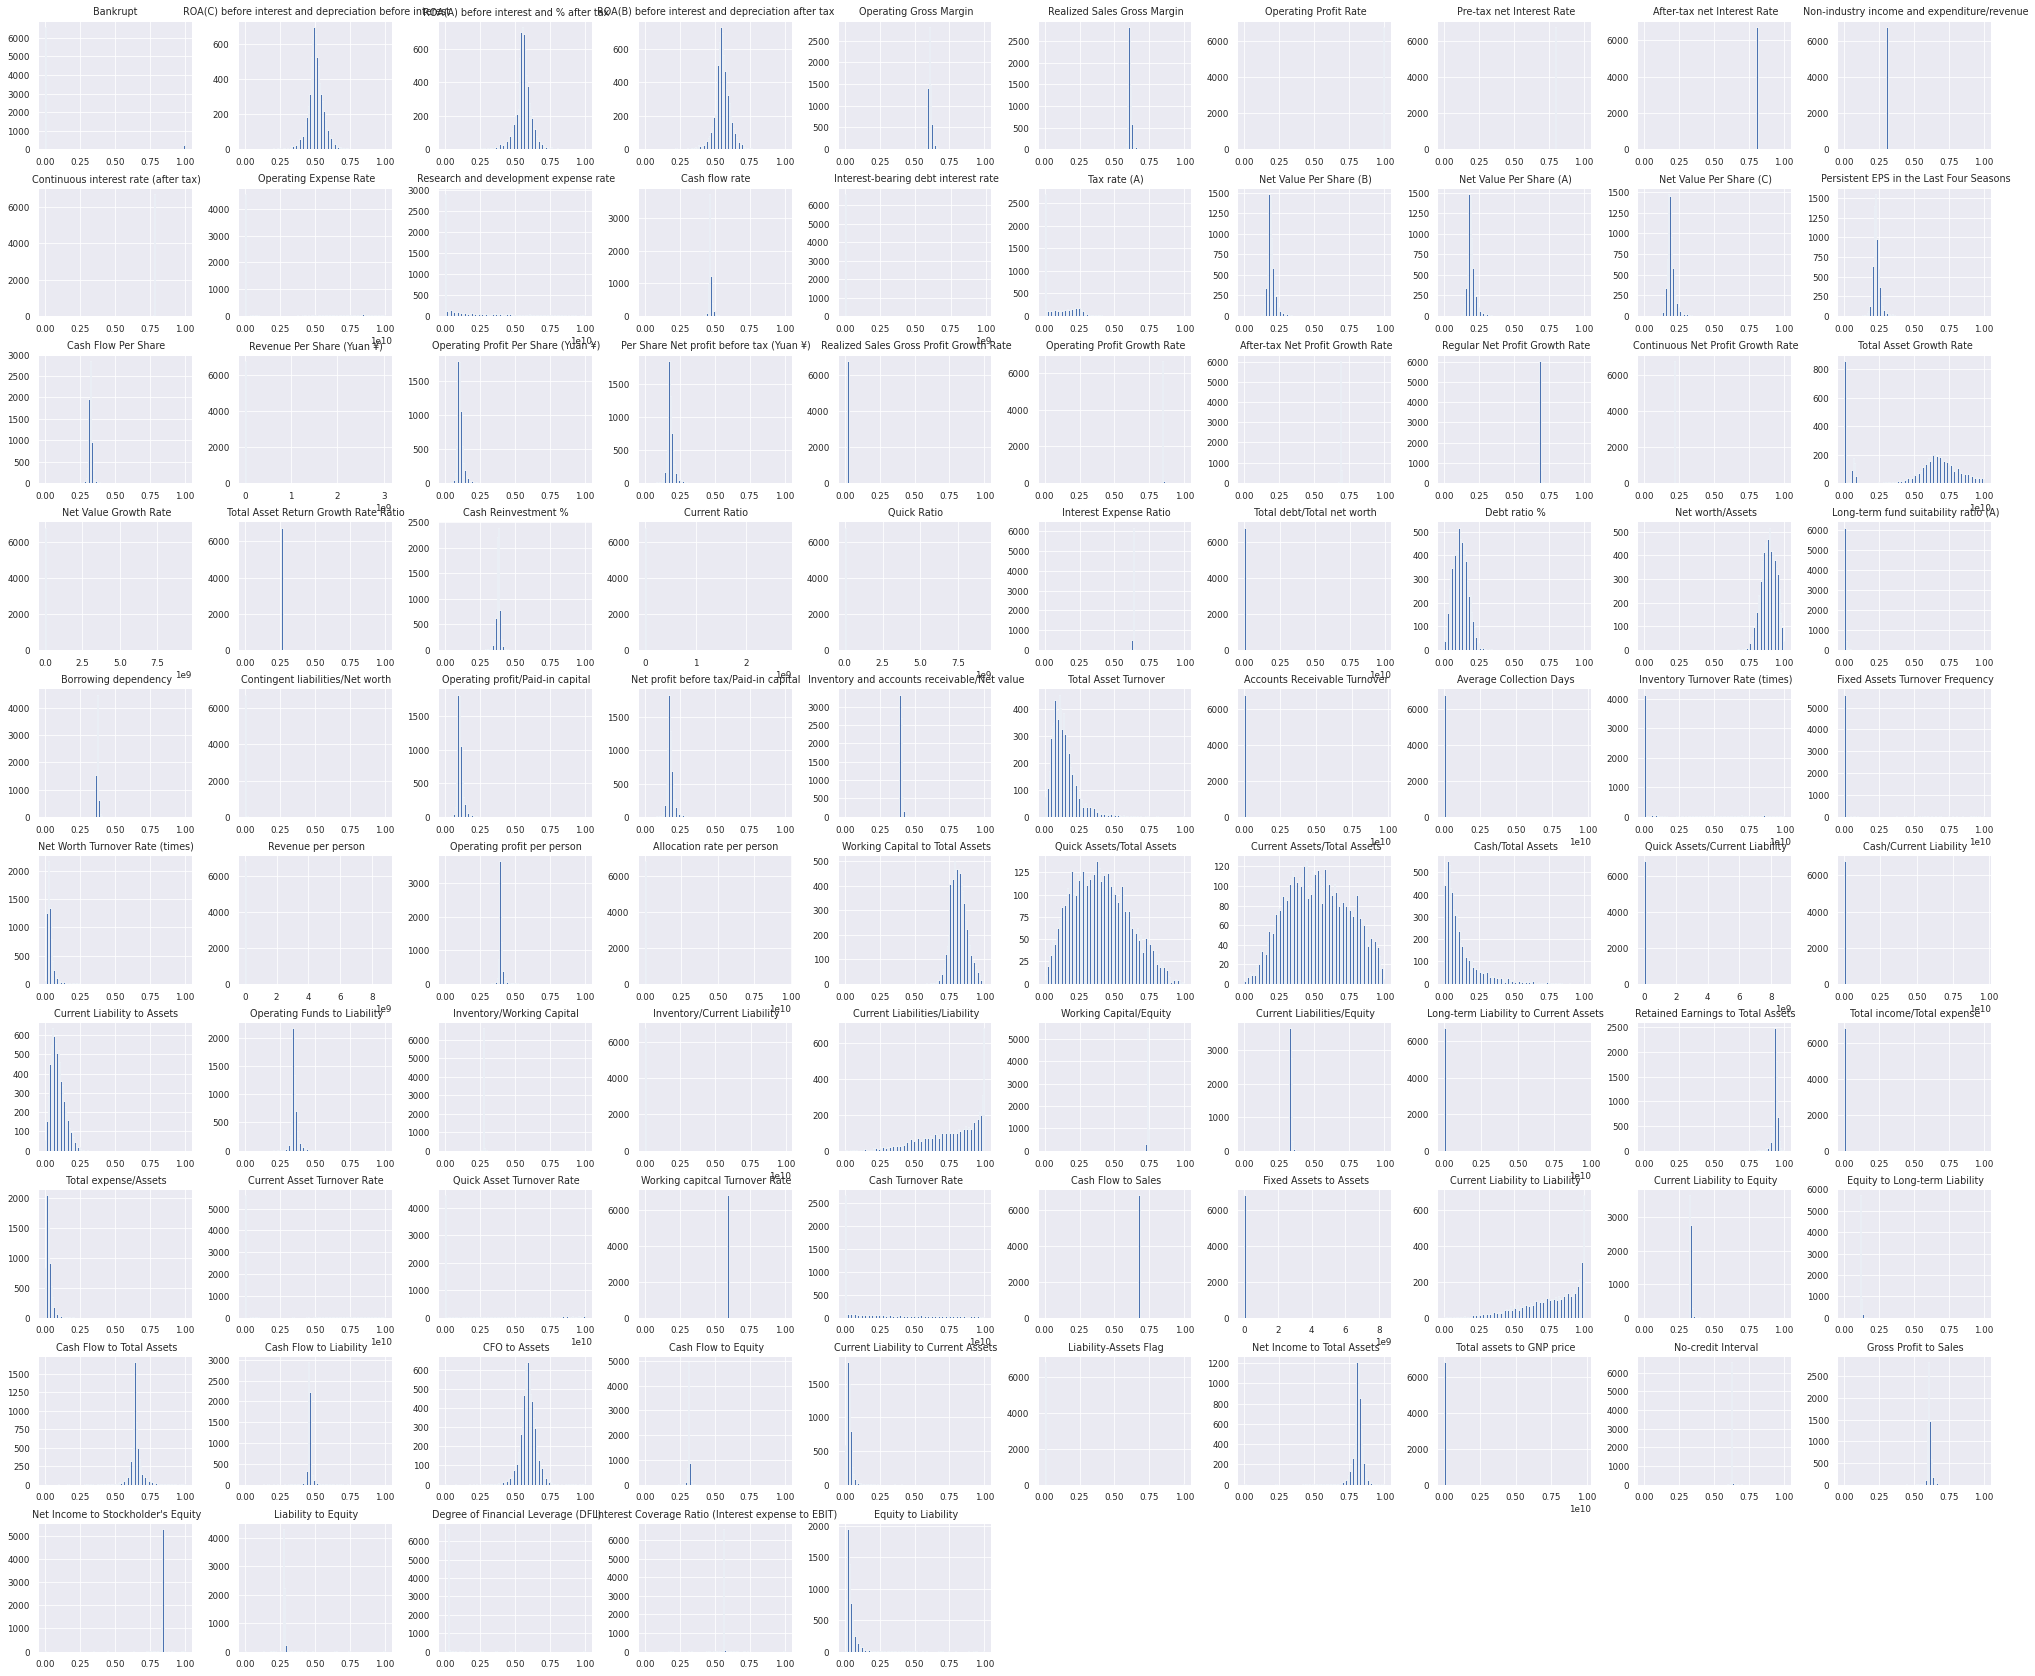

In [16]:
df.hist(figsize = (35,30), bins = 100)
plt.show() # Гистрограммы признаков

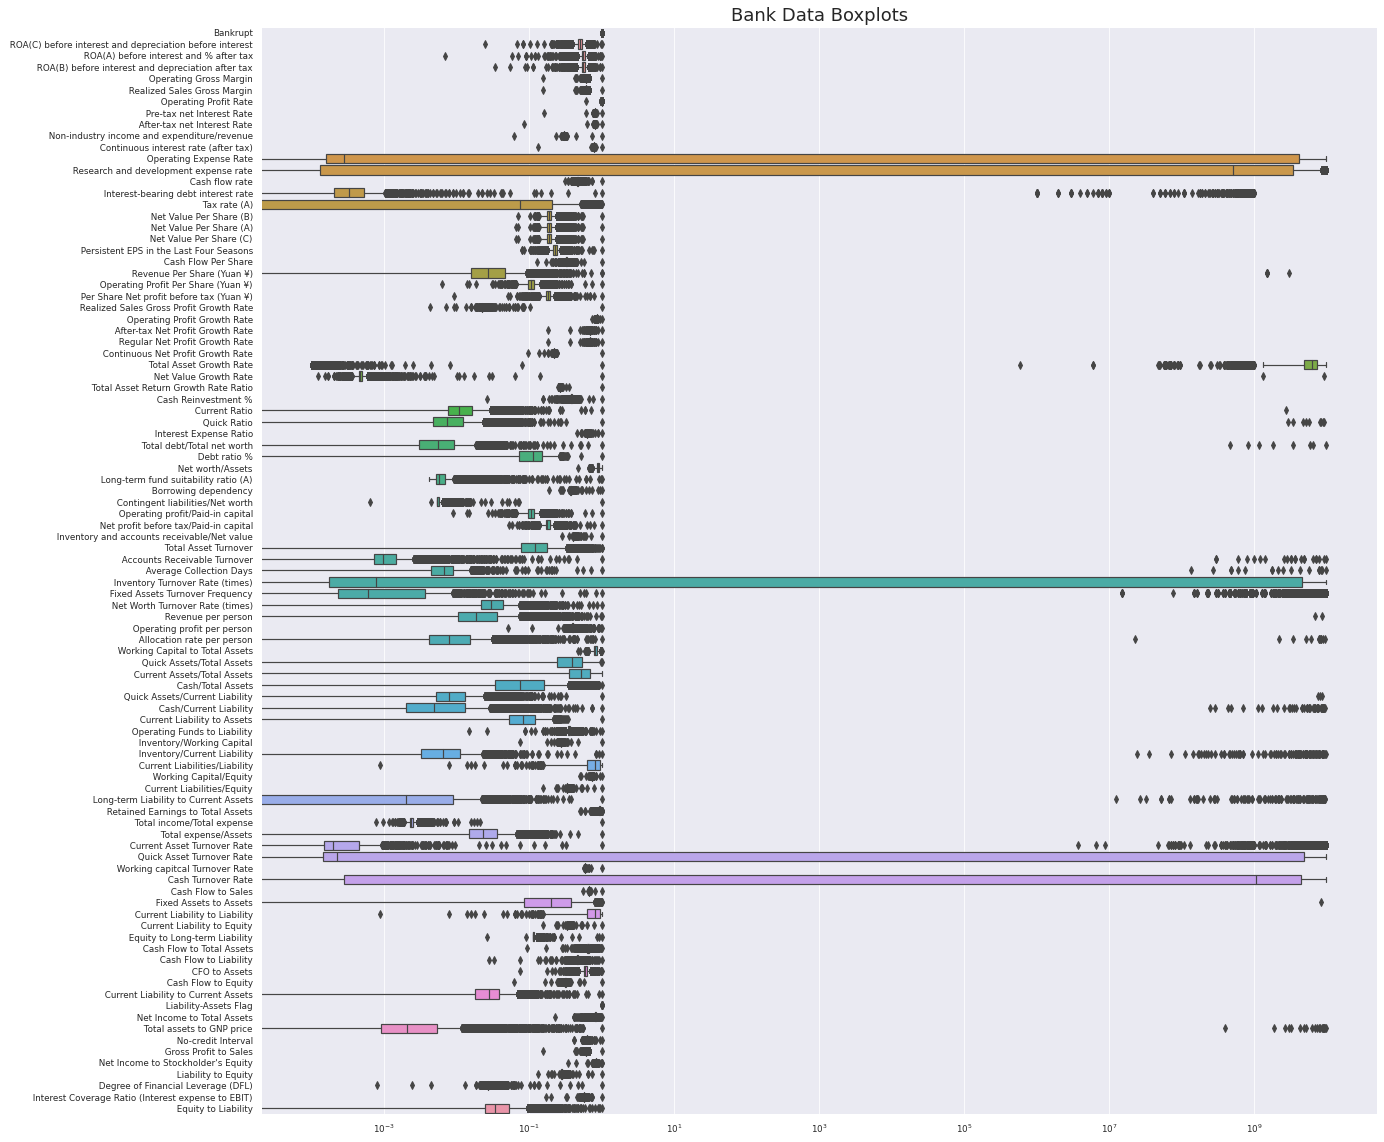

In [17]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show() # Ящики с усами (боксплоты)

Заметим, что большое количество признаков имеют отклонений (выбросов) - > удалим их

In [18]:
def outliers_removal(feature,feature_name,dataset):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    #print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    urange = q75 - q25
    #print('urange: {}'.format(urange))
    
    feat_cut_off = urange * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    #print(feature_name +' Lower: {}'.format(feat_lower))
    #print(feature_name +' Upper: {}'.format(feat_upper))

    df.loc[df[feature_name] > feat_upper, feature_name] = np.nan
    df.loc[df[feature_name] < feat_lower, feature_name] = np.nan
    #print('-' * 65)
    return dataset

In [19]:
for col in df.loc[:, df.columns != 'Bankrupt']:
    new_df = outliers_removal(df[col], str(col), df)

In [20]:
nulls_table(df) # процент отсутствующих значений

,column,nulls_%
92,Degree of Financial Leverage (DFL),22.041355
93,Interest Coverage Ratio (Interest expense to ...,20.838833
49,Fixed Assets Turnover Frequency,20.794838
71,Current Asset Turnover Rate,20.516205
29,Total Asset Growth Rate,20.252236
...,...,...
64,Current Liabilities/Liability,0.586596
38,Net worth/Assets,0.439947
37,Debt ratio %,0.439947
85,Liability-Assets Flag,0.117319


In [21]:
rows = df.shape[0]
columns = df.shape[1]

# удалим строки, в которых количество NaN элементов превышает 20% общего объема данных
df = df.dropna(thresh = round(columns*0.8, 0))
# удалим столбцы, в которых количество NaN элементов превышает 20% общего объема данных
df = df.dropna(axis = 1, thresh = round(rows*0.8, 0))

df.shape

(6287, 84)

In [22]:
nulls_table(df)

,column,nulls_%
27,Continuous Net Profit Growth Rate,13.233657
24,Operating Profit Growth Rate,12.979163
25,After-tax Net Profit Growth Rate,12.899634
26,Regular Net Profit Growth Rate,12.883728
68,Cash Flow to Sales,12.613329
...,...,...
49,Working Capital to Total Assets,0.556704
55,Current Liability to Assets,0.524893
70,Current Liability to Liability,0.493081
58,Current Liabilities/Liability,0.493081


In [23]:
for i in df.columns:
    df[i] = df[i].fillna(df[i].mean()) # Замена числовых признаков на среднее

In [24]:
nulls_table(df)

,column,nulls_%


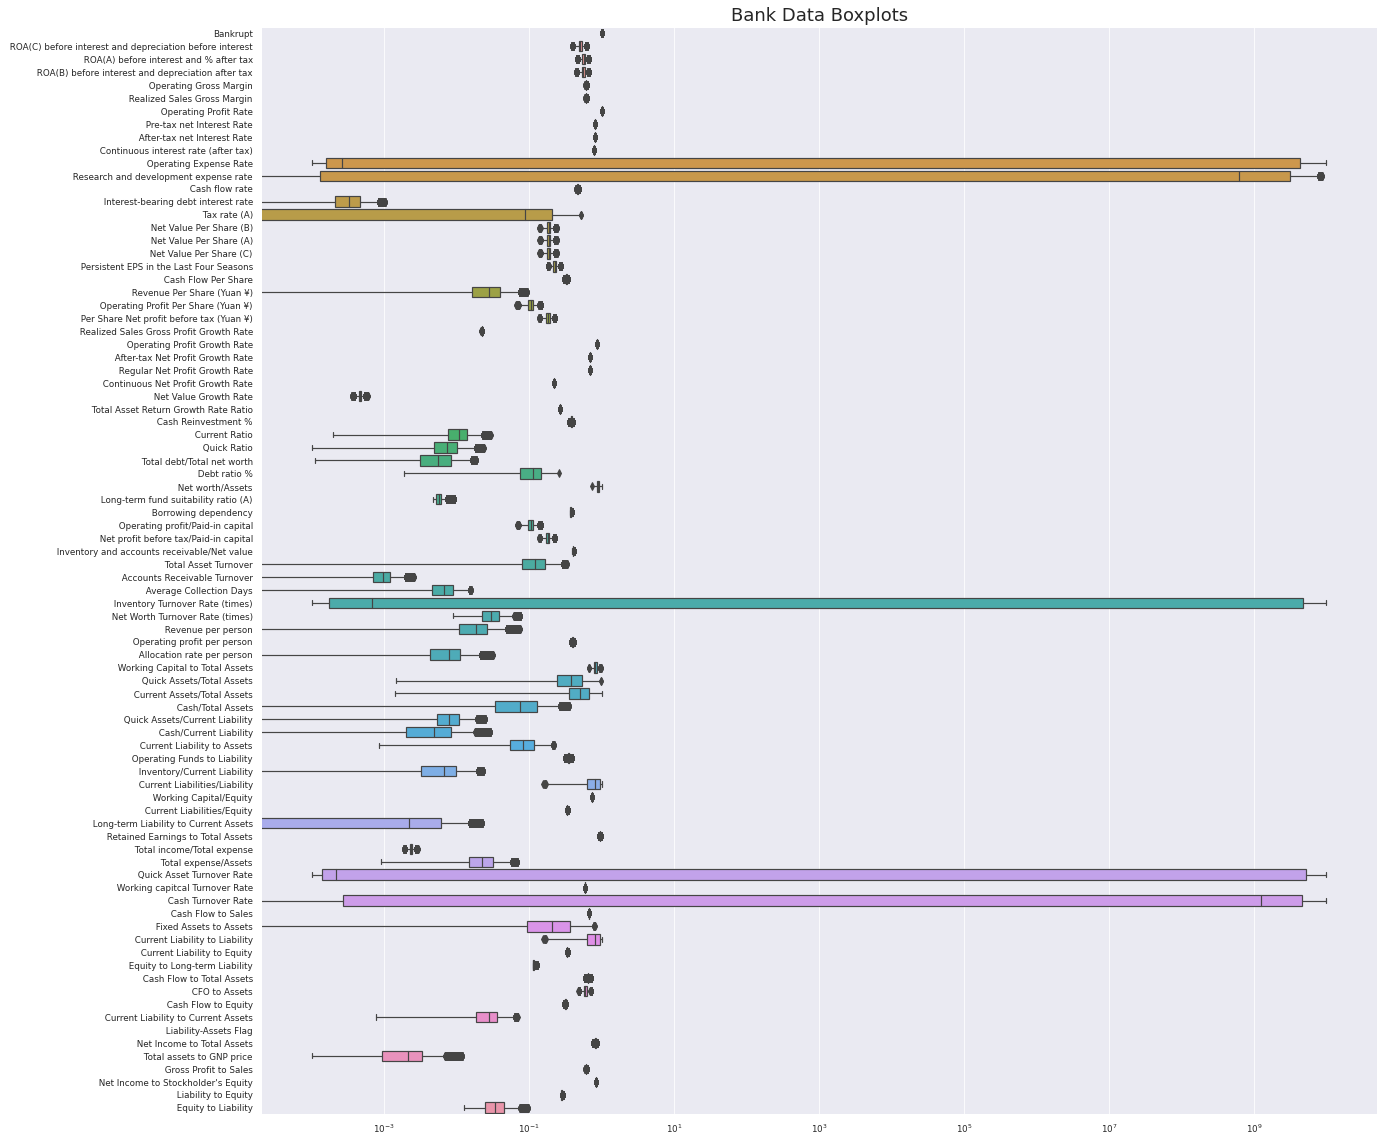

In [25]:
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = df, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show() # Ящики с усами (боксплоты)

In [26]:
# Снова проверим и удалим неинформативные признаки с помощью поиска уникальных значений (тк после удаления выбрасов и замены пропусков такие признаки могли появиться)
to_del = []
for col in df.columns:
  if len(df[col].unique()) == 1:
    to_del.append(col)

to_del

[' Liability-Assets Flag']

In [27]:
df = df.drop(to_del, axis = 1)

In [28]:
make_model(df, name = '-выбросы и пропуски')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,stage,accuracy_to_max,precision_to_min,recall_to_max,time
0,Исходные данные,0.967009,0.609559,0.510492,0.326454
1,-первичная обработка,0.972874,0.736784,0.513137,0.505876
2,-выбросы и пропуски,0.972973,0.486486,0.500000,0.270023


# Работа с признаками

## 3. Коррелирующие признаки

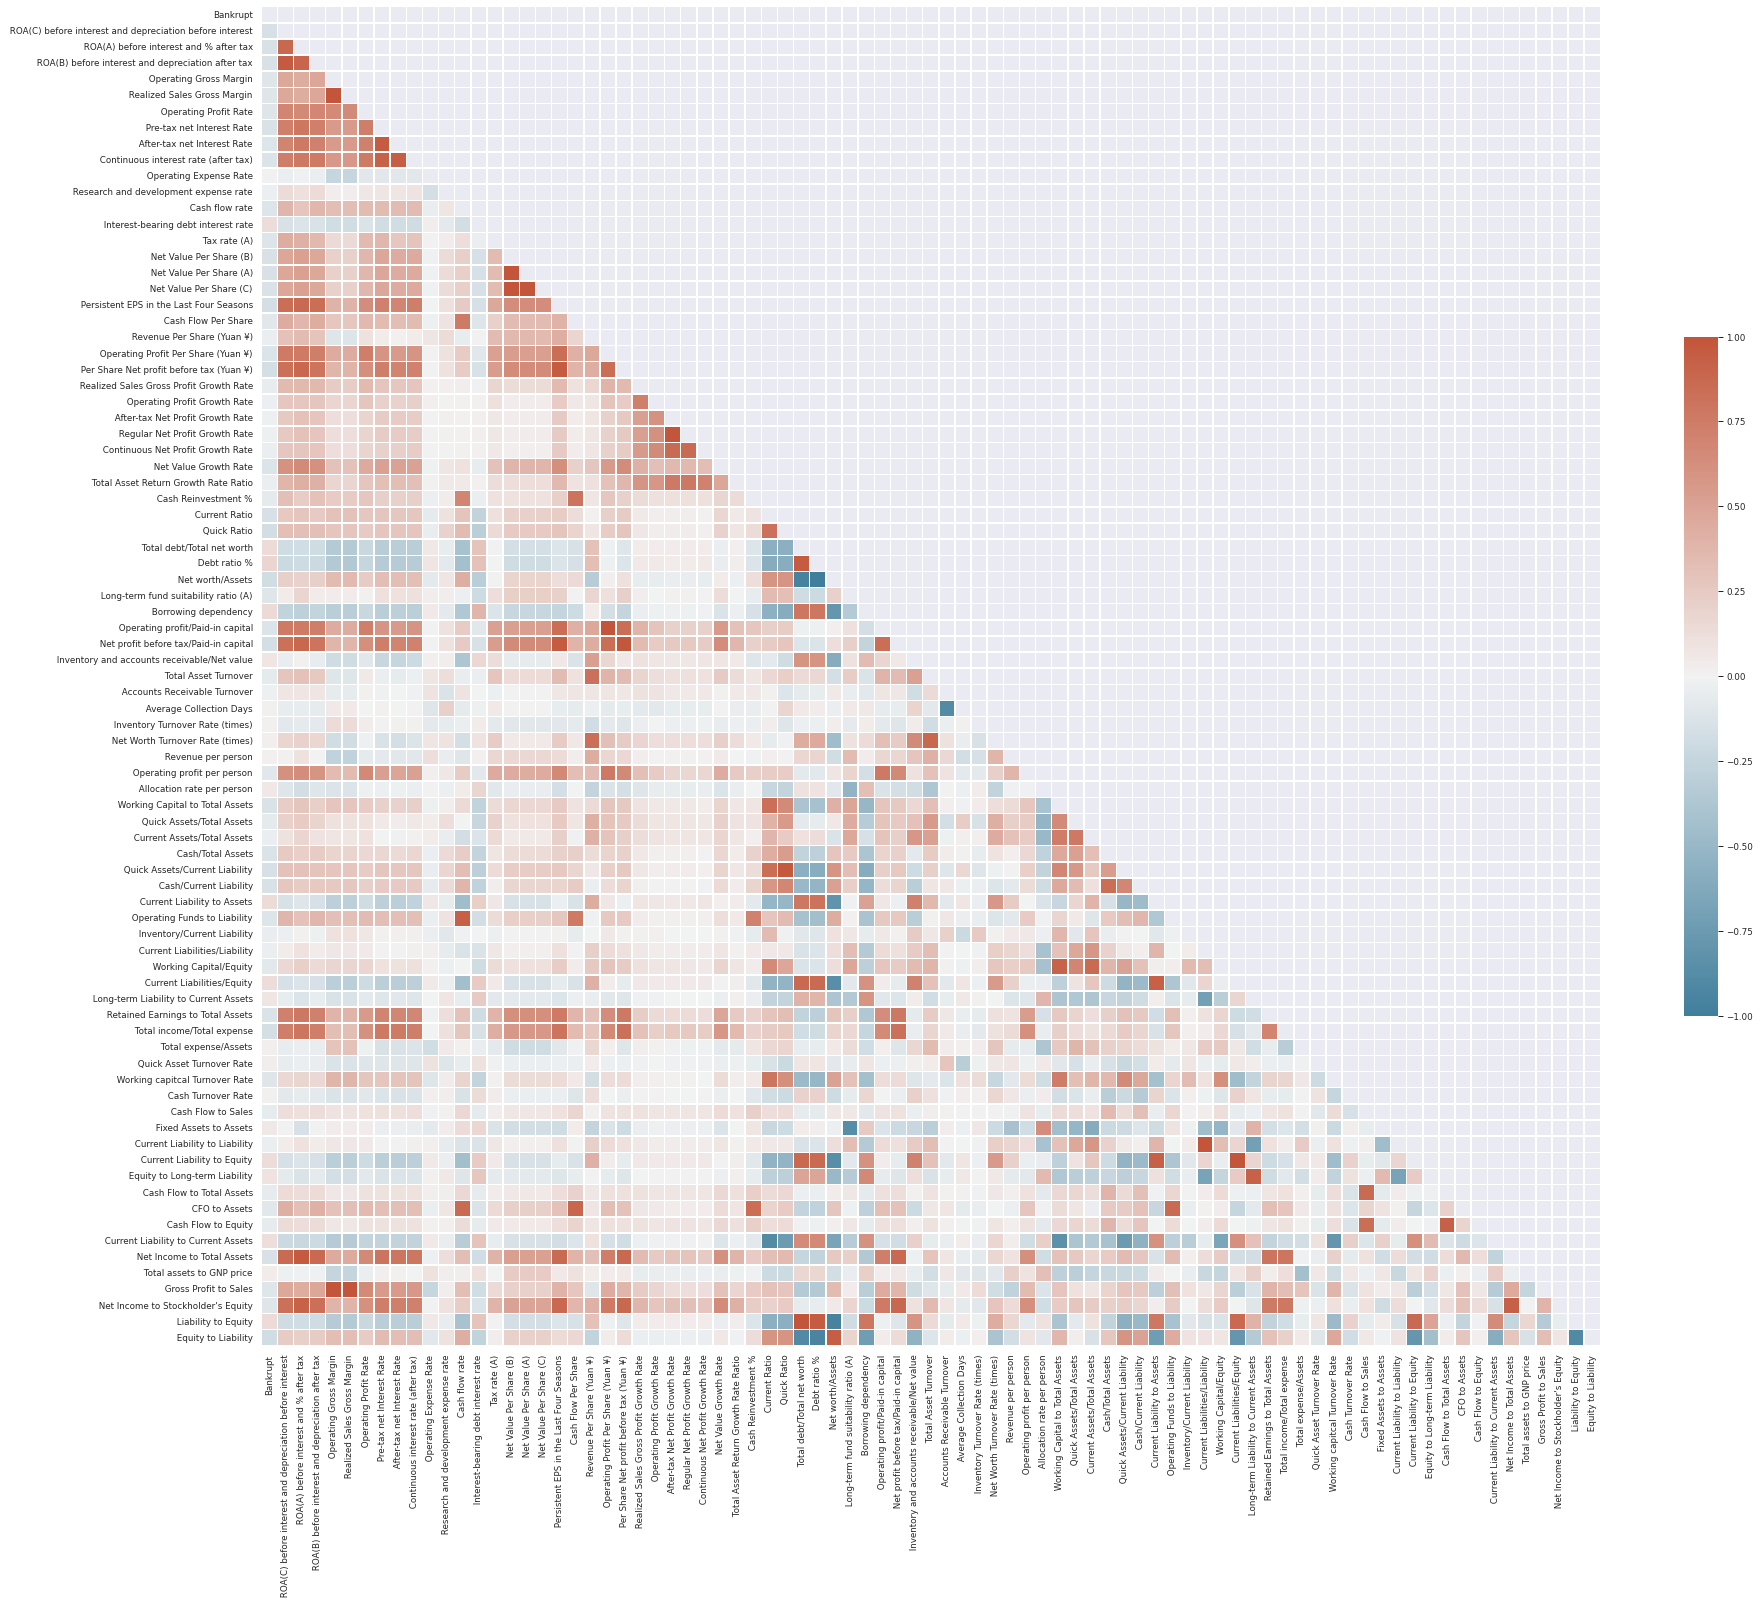

In [29]:
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [30]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

<ipython-input-30-f5b1a5ec98f5>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [31]:
df.shape

(6287, 83)

In [32]:
len(to_drop)

29

In [33]:
# Удаляем коррелирующие признаки
df = df.drop(to_drop, axis = 1)
df.shape

(6287, 54)

In [34]:
make_model(df, name = '-коррелирующие признаки')

,stage,accuracy_to_max,precision_to_min,recall_to_max,time
0,Исходные данные,0.967009,0.609559,0.510492,0.326454
1,-первичная обработка,0.972874,0.736784,0.513137,0.505876
2,-выбросы и пропуски,0.972973,0.486486,0.500000,0.270023
3,-коррелирующие признаки,0.972973,0.487261,0.499184,0.226185


## 00. - Избавление от несбалансированности данных -

По результатам проведения теста в конце поняла, что лучше не становится (и precision, и recall растут), поэтому предлагаю полностью исключить проверку на сбалансированность в работе, тк также эта проблема решается и использованием каких-то специальных методов непостредственно при построении модели (углубление в машинное обучение, другая тема курсовой работы)

In [35]:
print('Financially stable: ', round(df['Bankrupt'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Financially unstable: ', round(df['Bankrupt'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')

Financially stable:  97.87 % of the dataset
Financially unstable:  2.13 % of the dataset


**Для баланса и точности предсказания модели принято использовать методы обогащения классов, например, создать синтетические образцы методом SMOTE («Техника передискретизации синтетического меньшинства»)**

Он работает, создавая синтетические образцы из младшего класса вместо создания копий. Алгоритм выбирает два или более одинаковых экземпляра (используя меру расстояния) и возмущает один атрибут экземпляра за раз на случайную величину в пределах разницы с соседними экземплярами.

In [36]:
from imblearn.over_sampling import SMOTE
X = df.drop(['Bankrupt'], axis = 1) # факторные переменные
y = df.Bankrupt
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print(X[y==0].shape)
print(X[y==1].shape)

(6153, 53)
(6153, 53)


In [37]:
new_df = pd.concat([y, X], axis=1)
print('Financially stable: ', round(new_df['Bankrupt'].value_counts()[0]/len(new_df) * 100, 2), '% of the dataset')
print('Financially unstable: ', round(new_df['Bankrupt'].value_counts()[1]/len(new_df) * 100, 2), '% of the dataset')

Financially stable:  50.0 % of the dataset
Financially unstable:  50.0 % of the dataset


In [38]:
make_model(new_df, name = '-дисбаланс данных-')

,stage,accuracy_to_max,precision_to_min,recall_to_max,time
0,Исходные данные,0.967009,0.609559,0.510492,0.326454
1,-первичная обработка,0.972874,0.736784,0.513137,0.505876
2,-выбросы и пропуски,0.972973,0.486486,0.500000,0.270023
3,-коррелирующие признаки,0.972973,0.487261,0.499184,0.226185
4,-дисбаланс данных-,0.883428,0.891724,0.882375,0.747694


## 6. Используем метод взаимной классификации для определения наиболее значимых признаков
измеряет зависимость функций от целевого значения

In [39]:
X = df.drop(['Bankrupt'], axis = 1) # факторные переменные
y = df.Bankrupt

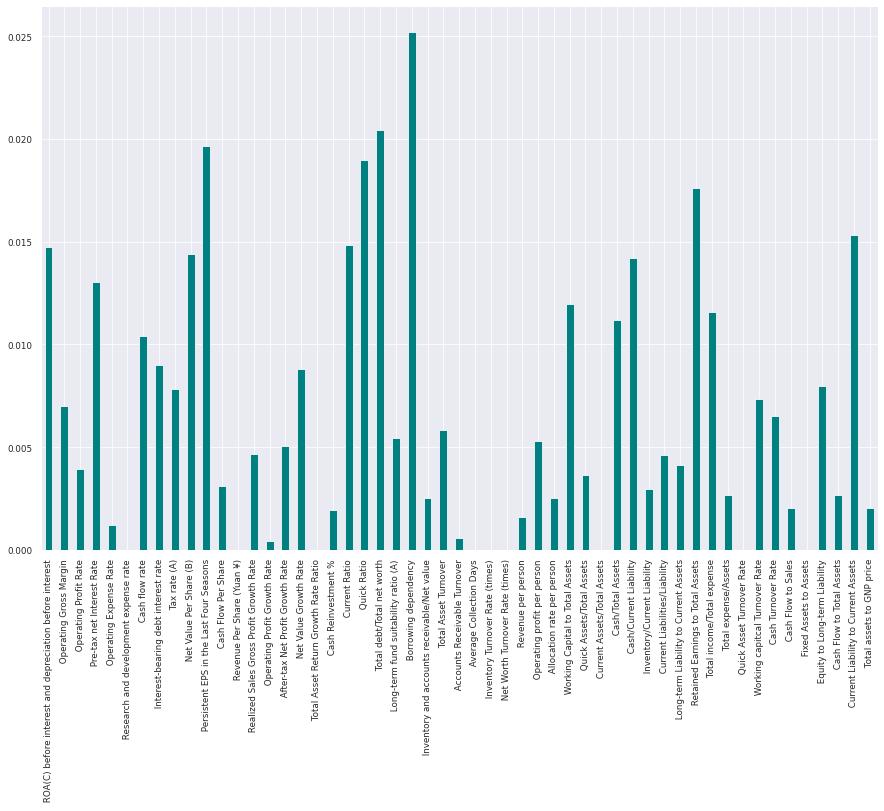

In [40]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize = (15,10))
importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, X.columns[0:len(df.columns)-1])
feature_importances.plot(kind='bar', color='teal')
plt.show()

In [41]:
feature_importances = pd.DataFrame({'column':feature_importances.index, 'imortance': feature_importances.values}).sort_values(by = 'imortance')
feature_importances.head()

,column,imortance
48,Fixed Assets to Assets,0.0
44,Quick Asset Turnover Rate,0.0
5,Research and development expense rate,0.0
35,Current Assets/Total Assets,0.0
29,Net Worth Turnover Rate (times),0.0


In [42]:
# Удалим совсем незначимые признаки (важность = 0)
unimportant_features = list(feature_importances[feature_importances.imortance == 0].column)
unimportant_features

[' Fixed Assets to Assets',
 ' Quick Asset Turnover Rate',
 ' Research and development expense rate',
 ' Current Assets/Total Assets',
 ' Net Worth Turnover Rate (times)',
 ' Inventory Turnover Rate (times)',
 ' Average Collection Days',
 ' Revenue Per Share (Yuan ¥)',
 ' Total Asset Return Growth Rate Ratio']

In [43]:
df = df.drop(unimportant_features, axis = 1)

In [44]:
df.shape

(6287, 45)

In [45]:
make_model(df, name = '-незначимые признаки')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,stage,accuracy_to_max,precision_to_min,recall_to_max,time
0,Исходные данные,0.967009,0.609559,0.510492,0.326454
1,-первичная обработка,0.972874,0.736784,0.513137,0.505876
2,-выбросы и пропуски,0.972973,0.486486,0.500000,0.270023
3,-коррелирующие признаки,0.972973,0.487261,0.499184,0.226185
4,-дисбаланс данных-,0.883428,0.891724,0.882375,0.747694
5,-незначимые признаки,0.978537,0.489269,0.500000,0.217443


# Итог

Видим, что в результате (игнорируя ступень "-дисбаланс данных-") наша модель улучшила показатели точности и теперь ее можно использовать для модели машинного обучения

In [46]:
df.head()

,Bankrupt,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,Operating Expense Rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),...,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Equity to Long-term Liability,Cash Flow to Total Assets,Current Liability to Current Assets,Total assets to GNP price
1,1,0.464291,0.610235,0.998946,0.797380,2.897851e-04,0.461867,0.000647,0.000000,0.182251,...,0.931065,0.002226,0.025516,0.593916,2.490000e+09,0.671570,0.120916,0.641100,0.047775,0.008323
2,1,0.426071,0.601450,0.998857,0.797483,2.361297e-04,0.458521,0.000790,0.000000,0.177911,...,0.938494,0.002060,0.021387,0.593965,7.610000e+08,0.671571,0.117922,0.642765,0.025346,0.002703
3,1,0.399844,0.583541,0.999034,0.797483,1.078888e-04,0.465705,0.000449,0.000000,0.154187,...,0.938494,0.002350,0.024161,0.593889,2.030000e+09,0.671575,0.120760,0.646424,0.067250,0.003252
4,1,0.465022,0.598783,0.998973,0.797366,7.890000e+09,0.462746,0.000686,0.000000,0.167502,...,0.913850,0.002224,0.026385,0.593915,8.240000e+08,0.671563,0.110933,0.622374,0.047725,0.003878
7,0,0.508361,0.601738,0.999009,0.797449,9.000000e+09,0.467024,0.000630,0.157607,0.176984,...,0.935449,0.002360,0.025482,0.593937,7.340000e+08,0.671572,0.114508,0.641553,0.030201,0.010005


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6287 entries, 1 to 6817
Data columns (total 45 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt                                                  6287 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6287 non-null   float64
 2    Operating Gross Margin                                   6287 non-null   float64
 3    Operating Profit Rate                                    6287 non-null   float64
 4    Pre-tax net Interest Rate                                6287 non-null   float64
 5    Operating Expense Rate                                   6287 non-null   float64
 6    Cash flow rate                                           6287 non-null   float64
 7    Interest-bearing debt interest rate                      6287 non-null   float64
 8    Tax rate (A)     